## Import all required libraries

In [1]:
import ixmp
import message_ix
import numpy as np
import pandas as pd
import yaml

from collections.abc import Mapping
from itertools import repeat
from message_ix.models import MESSAGE_ITEMS
from message_ix.utils import make_df
from message_ix.tools.add_dac import *

%matplotlib inline

<IPython.core.display.Javascript object>

C:\Users\pratama\Documents\GitHub\MESSAGEix\message_ix\message_ix\reporting\__init__.py:98: FutureWarning: Importing from genno.computations will be deprecated in a future version; use genno.operator instead.
  ("tom:nl-t-yv-ya", (genno.computations.add, "fom:nl-t-yv-ya", "vom:nl-t-yv-ya")),


In [2]:
def plotvars(scenario):
    # CO2 Emission
    emiss = scenario.var("EMISS")
    emiss = emiss.loc[(emiss['type_tec'] == 'all') & 
                      (emiss['node'] == 'World') & 
                      (emiss['emission'] == 'TCE')]
    emiss_plot = emiss[['year','lvl']].set_index(['year']).div(1000)

    # CO2 Removal
    removal = scenario.var("EMISS")
    removal = removal.loc[(removal['type_tec'] == 'all') & 
                          (removal['node'] == 'World') & 
                          (removal['emission'] == 'CO2_storage')]
    removal_plot = removal[['year','lvl']].set_index(['year']).div(1000)

    # CO2 Prices
    CO2Price = (scenario.var("PRICE_EMISSION")
                .loc[scenario.var("PRICE_EMISSION")['type_emission'] == 'TCE'][['year','lvl']]
                .set_index(['year'])).div(1000)
    
    
    plt.figure(figsize=(4,4))
    # Plottings
    plt.plot(emiss_plot, label='CO2 Emission')
    plt.plot(removal_plot, label='CO2 Removal')
    plt.plot(CO2Price, label='CO2 Price')
    
    plt.ylim(-10,40)
    plt.ylabel("thousands of var unit")
    
    plt.legend()
    plt.show()

In [3]:
# REGIONAL CO2 STORAGE POTENTIAL
# read storage potential in GtCO2
potentials = pd.read_excel("storage_by_country.xlsx").set_index("ISO")

# read regional country lists
reg_list_path = "region_code_list.yaml"

with open(reg_list_path, 'r') as file:
    reg_data = yaml.safe_load(file)

# creating R12 potentials dataframe
R12_potential = pd.DataFrame(columns=["Potential"])

for reg in set(reg_data.keys()) - {"World"}:
    val = potentials.loc[reg_data[reg]["child"]]["Potential"].sum()
    R12_potential.loc[reg] = np.round(1000*val/3.667, 3) # convert to MtCO2
    
R12_pot = R12_potential.div(90)

In [4]:
R12_potential

,Potential
R12_EEU,1808.370
R12_RCPA,3754.285
R12_CHN,15712.475
R12_FSU,83310.661
R12_PAS,21108.578
R12_AFR,61399.222
R12_WEU,11793.358
R12_SAS,4765.219
R12_NAM,58983.981
R12_PAO,34233.825


In [5]:
# SSPs and scenarios lists
ssps = ["LED","SSP1","SSP2","SSP3","SSP4","SSP5"]
ssps = ["SSP1","SSP2","SSP5"]
ssps = ["LED","SSP1","SSP2","SSP4"]

max_rate = np.round(15000/3.667,0) # convert MtCO2/y to MtC/y



## Create baseline and emission bound scenarios with split CO2 infrastructure

-------- LED runs --------
DAC baseline|Old setup CO2 infrastructure


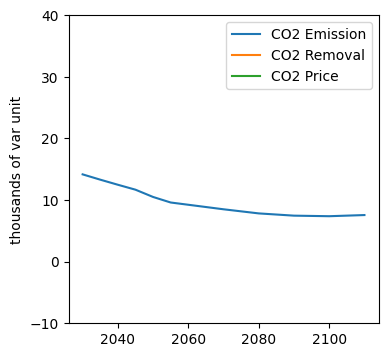

DAC baseline|Split CO2 infrastructure


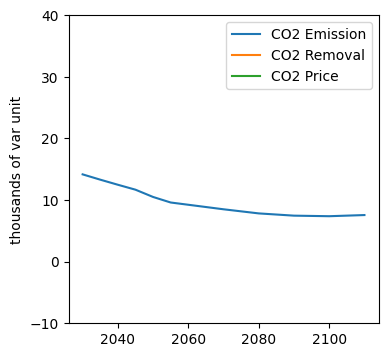

-------- SSP1 runs --------
DAC baseline|Old setup CO2 infrastructure


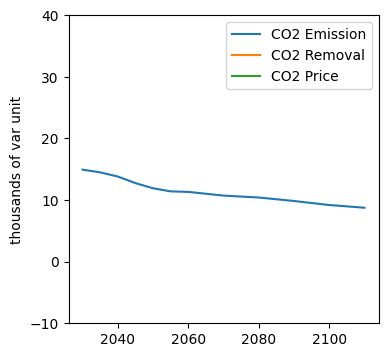

DAC baseline|Split CO2 infrastructure


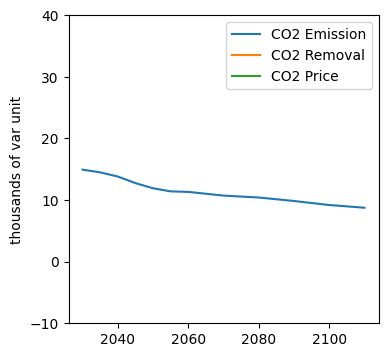

-------- SSP2 runs --------
DAC baseline|Old setup CO2 infrastructure


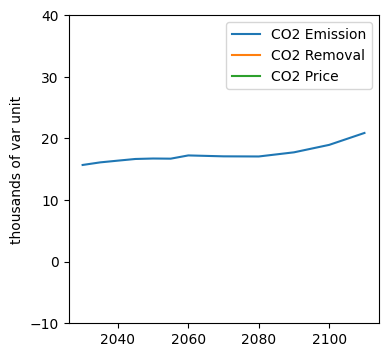

DAC baseline|Split CO2 infrastructure


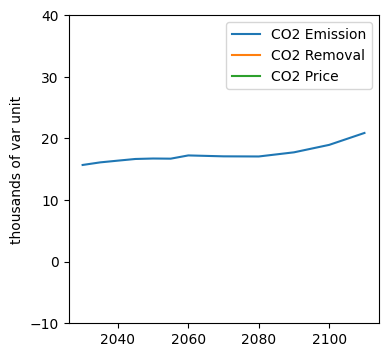

-------- SSP4 runs --------
DAC baseline|Old setup CO2 infrastructure


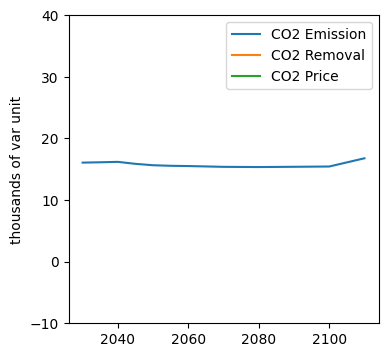

DAC baseline|Split CO2 infrastructure


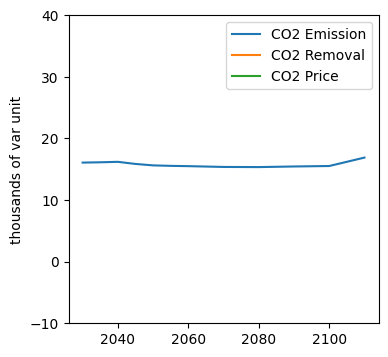

In [6]:
modes = ["M1","M2","M3"]
len_periods = {2025:5, 2030:5, 2035:5, 2040:5, 
               2045:5, 2050:5, 2055:5, 2060:5, 
               2070:10, 2080:10, 2090:10, 2100:10, 2110:10}

for ssp in ssps:
    print(f"-------- {ssp} runs --------")
    # CONNECT TO DATABASE
    mp = ixmp.Platform()

    # Clone baseline- & crate DAC baseline- scenarios 
    base = message_ix.Scenario(mp, model=f'SSP_dev_{ssp}_v1.0_Blv1.0', 
                               scenario="baseline_prep_lu_bkp_solved_materials_2030_macro")
    base_scen = base.clone(
        f"SSP_dev_{ssp}_v1.0_materials-dac",
        "baseline",
        f"{ssp}_dev for MESSAGE-Materials with DAC",
        keep_solution=False, 
    )
    base_scen.check_out()

    year_df = base_scen.vintage_and_active_years()
    vintage_years, act_years = year_df["year_vtg"], year_df["year_act"]
    model_horizon = base_scen.set("year")
    
    nodes = [node for node in base_scen.set("node") if node != "World"]
    years = [year for year in base_scen.set("year") if year > 2025]
    
    base_scen.commit(
        comment=f"{ssp}_dev DAC baseline with old CCS infrastructure setup"
    )
    base_scen.set_as_default()

    base_scen.solve(solve_options={'scaind': '-1'})
    
    print("DAC baseline|Old setup CO2 infrastructure")
    plotvars(base_scen)
    
    # create 1000f scenario
    #> co2bound_base = base_scen.clone(
    #>     f"SSP_dev_{ssp}_v1.0_materials-dac",
    #>     "1000f",
    #>     f"{ssp}_dev for MESSAGE-Materials with DAC 1000f",
    #>     keep_solution=False, 
    #> )
    #> co2bound_base.check_out()

    ## add emission bound
    #> co2bound_base.add_par('bound_emission', ['World', 'TCE', 'all', 'cumulative'], value=4046, unit="tC")
    
    ## run and report scenario
    #> co2bound_base.commit(comment=f"{ssp}_dev 1000f without DAC scenario")
    #> co2bound_base.set_as_default()

    #> co2bound_base.solve(solve_options={'scaind': '-1'}) # solve_options={'barcrossalg': '2','scaind':'-1'}
    #> co2bound_base.var("OBJ")["lvl"]
    
    #> print("DAC 1000f|Old setup CO2 infrastructure")
    #> plotvars(co2bound_base)
    
    # calling baseline scenario
    #> base_scen = message_ix.Scenario(mp, model=f'SSP_dev_{ssp}_v1.0_materials-dac', scenario="baseline")
    
    #> year_df = base_scen.vintage_and_active_years()
    #> vintage_years, act_years = year_df["year_vtg"], year_df["year_act"]
    #> model_horizon = base_scen.set("year")
    
    #> nodes = [node for node in base_scen.set("node") if node != "World"]
    #> years = [year for year in base_scen.set("year") if year > 2025]
    
    # Create DAC baseline scenario with split CO2 T&D infrastructure
    scen = base_scen.clone(
        f"SSP_dev_{ssp}_v1.0_materials-dac-co2split",
        "baseline",
        "dac baseline with split CO2 T&D",
        keep_solution=False, 
    )
    scen.check_out()

    ## remove old setup
    ### remove relations
    params = ['relation_activity']

    techs = ['co2_tr_dis', 'bco2_tr_dis',
             'bio_istig_ccs','biomass_NH3_ccs','bio_ppl_co2scr','eth_bio_ccs','meth_bio_ccs','h2_bio_ccs','liq_bio_ccs',
             'bf_ccs_steel','c_ppl_co2scr','clinker_dry_ccs_cement','clinker_wet_ccs_cement',
             'coal_adv_ccs','coal_NH3_ccs','dri_gas_ccs_steel','fueloil_NH3_ccs','g_ppl_co2scr','gas_cc_ccs', 'gas_NH3_ccs',
             'h2_coal_ccs','h2_smr_ccs','igcc_ccs','meth_coal_ccs','meth_ng_ccs','syn_liq_ccs']
    
    rels = ['co2_trans_disp','bco2_trans_disp','CO2_Emission_Global_Total', 'CO2_Emission','CO2_PtX_trans_disp_split']

    for par in params:
        scen.remove_par(par, scen.par(par,{'technology':techs,'relation':rels}))
    
    #### remove relation set not automatically removed in add_tech
    scen.remove_set('relation','CO2_PtX_trans_disp_split')
    
    ## remove pipelines
    ### list of parameters to remove
    params = ['inv_cost','fix_cost','input','capacity_factor','technical_lifetime',
              'construction_time','abs_cost_activity_soft_up','growth_activity_lo',
              'level_cost_activity_soft_lo','level_cost_activity_soft_up','relation_activity',
              'var_cost','output','emission_factor','soft_activity_lo','soft_activity_up',
              'growth_activity_up','initial_activity_up']

    pipes = ['co2_tr_dis', 'bco2_tr_dis']
    
    for par in params:
        scen.remove_par(par, scen.par(par,{'technology':pipes}))

    ## remove sets    
    scen.remove_set('technology',pipes)
    scen.remove_set('relation',rels[0:2])
    
    # add new setup
    ## add CO2_storage
    ## scen.add_set('emission',"CO2_storage")

    ## setup pipelines and storage technologies
    filepath = f'C:/Users/pratama/Documents/GitHub/MESSAGEix/message_ix/tutorial/dac_scenarios/SSPs/ssp_data/data_default/co2infrastructure_data_{ssp}dev.yaml'
    add_tech(scen,filepath=filepath)
    
    ## removing some pipelines and storage parameters
    newpipesnstors = ['co2_stor','co2_trans1', 'co2_trans2']
    pars2remove = ['var_cost','input','output','emission_factor','capacity_factor']
    for par in pars2remove:
        df = scen.par(par,{'technology':newpipesnstors})
        df= df.loc[df['year_vtg'] != df['year_act']]
        scen.remove_par(par, df)

    ## removing excess year_act
    pars2remove = ['output']
    for par in pars2remove:
        df = scen.par(par,{'technology':techs})
        df = df.loc[df['year_act'] > df['year_vtg'].add(30)]
        scen.remove_par(par, df)
    
    ## setup dac technologies
    filepath = f'C:/Users/pratama/Documents/GitHub/MESSAGEix/message_ix/tutorial/dac_scenarios/SSPs/ssp_data/data_default/daccs_setup_data_{ssp}dev.yaml'
    add_tech(scen,filepath=filepath)
    
    ## removing some dac parameters
    newpipesnstors = ['co2_trans1']
    pars2remove = ['emission_factor','capacity_factor','var_cost','input','output']
    for par in pars2remove:
        df = scen.par(par,{'technology':newpipesnstors})
        df= df.loc[df['year_vtg'] != df['year_act']]
        scen.remove_par(par, df)

    ## removing excess year_act
    pars2remove = ['capacity_factor','fix_cost','input','output']
    techs = ['dac_lt', 'dac_hte', 'dac_htg']
    for par in pars2remove:
        df = scen.par(par,{'technology':techs})
        df = df.loc[df['year_act'] > df['year_vtg'].add(30)]
        scen.remove_par(par, df)

    # SETUP TECHNOLOGY AND RELATIONS TO TRACK CUMULATIVE STORAGE
    ## adding set and dummy technologies
    scen.add_set("technology","co2_storcumulative")
    for mode in modes:
        scen.add_set("relation",f"co2_storcum_{mode}")


    ## create relation activity
    list_relation = []
    for node in nodes:
        for mode in modes:
            for yr in years:
                ya = [y for y in years if y <= yr]
                relact_co2stor = make_df("relation_activity",
                            relation=f"co2_storcum_{mode}",
                            node_rel=node,
                            year_rel=yr,
                            node_loc=node,
                            technology="co2_stor",
                            year_act=ya,
                            mode=mode,
                            value= [-1 * len_periods[y] for y in ya],
                            unit = "-"
                       )

                relact_co2storcumulative = make_df("relation_activity",
                            relation=f"co2_storcum_{mode}",
                            node_rel=node,
                            year_rel=yr,
                            node_loc=node,
                            technology="co2_storcumulative",
                            year_act=yr,
                            mode=mode,
                            value=1,
                            unit = "-"
                       )
                list_relation += [relact_co2stor, relact_co2storcumulative]
    df_relation = pd.concat(list_relation)

    ## create relation bounds
    list_rel_eq = []
    for node in nodes:
        for mode in modes:
            rel_eq = make_df("relation_upper",
                    relation = f"co2_storcum_{mode}",
                    node_rel = node,
                    year_rel = years,
                    value = 0,
                    unit = "-"
                   )
            list_rel_eq += [rel_eq]
    df_rel_eq = pd.concat(list_rel_eq)

    ## adding parameters
    scen.add_par("relation_activity", df_relation)
    scen.add_par("relation_upper", df_rel_eq)
    scen.add_par("relation_lower", df_rel_eq)
    
    ## adding set up for limiting CO2 storage availabilities
    nodes = [node for node in nodes if node not in ["R12_GLB","World"]]
    df_list = []
    for node in nodes:
        for year in years:
            df = make_df("bound_activity_up",
                         node_loc=node,
                         technology="co2_storcumulative",
                         year_act=year,
                         mode="all",
                         time="year",
                         value = R12_pot.loc[node,"Potential"]*90,
                         unit = "???",
                        )
            df_list += [df]
    df_stor = pd.concat(df_list)
    
    scen.add_par("bound_activity_up", df_stor)

    ## adding injection rate limit <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< need global injection technology to aggregate global stor

    # SETUP TECHNOLOGY AND RELATIONS TO LIMIT GLOBAL INJECTION RATES
    ## adding set and dummy technologies
    scen.add_set("technology","co2_stor_glb")
    for mode in modes:
        scen.add_set("relation",f"co2_storglobal_{mode}")


    ## create relation activity
    list_relation = []
    for mode in modes:
        for yr in years:
            for node in nodes:
                relact_co2stor = make_df("relation_activity",
                            relation=f"co2_storglobal_{mode}",
                            node_rel="R12_GLB",
                            year_rel=yr,
                            node_loc=node,
                            technology="co2_stor",
                            year_act=yr,
                            mode=mode,
                            value= -1,
                            unit = "-"
                       )
                list_relation += [relact_co2stor]
            relact_co2stor_glb = make_df("relation_activity",
                        relation=f"co2_storglobal_{mode}",
                        node_rel="R12_GLB",
                        year_rel=yr,
                        node_loc="R12_GLB",
                        technology="co2_stor_glb",
                        year_act=yr,
                        mode=mode,
                        value=1,
                        unit = "-"
                   )
            list_relation += [relact_co2stor_glb]
    df_relation = pd.concat(list_relation)

    ## create relation bounds
    list_rel_eq = []
    for mode in modes:
        rel_eq = make_df("relation_upper",
                relation = f"co2_storglobal_{mode}",
                node_rel = "R12_GLB",
                year_rel = years,
                value = 0,
                unit = "-"
               )
        list_rel_eq += [rel_eq]
    df_rel_eq = pd.concat(list_rel_eq)

    ## adding parameters
    scen.add_par("relation_activity", df_relation)
    scen.add_par("relation_upper", df_rel_eq)
    scen.add_par("relation_lower", df_rel_eq)
    
    df_list = []
    for year in years:
        df = make_df("bound_activity_up",
                     node_loc="R12_GLB",
                     technology="co2_stor_glb",
                     year_act=year,
                     mode="all",
                     time="year",
                     value = max_rate,
                     unit = "???",
                    )
        df_list += [df]
    df_co2ratelim = pd.concat(df_list)
    
    ## adding parameters
    scen.add_par("bound_activity_up", df_co2ratelim)
    
    ## adding relation_upper and _lower for market penetration limit
    rels = ["DAC_mpen_c"]
    df_list = []
    for rel in rels:
        for node in nodes:
            df = make_df("relation_upper",
                         relation=rel,
                         node_rel=node,
                         year_rel=list(sorted(set(act_years))),
                         unit = "-",
                         value = 0
                        )
            df_list = df_list + [df]
    dfpar2add = pd.concat(df_list)
    scen.add_par("relation_upper", dfpar2add)
    scen.add_par("relation_lower", dfpar2add)
    
    scen.commit(comment=f"{ssp} baseline scenario with dac and split CO2 infrastructure")
    scen.set_as_default()
    
    scen.solve(solve_options={'scaind':'-1'})
    
    print("DAC baseline|Split CO2 infrastructure")
    plotvars(scen)
    
    # create dac 1000f scenario
    #> co2bound_scen = scen.clone(
    #>     f"SSP_dev_{ssp}_v1.0_materials-dac-co2split",
    #>     "1000f",
    #>     "dac 1000f carbon budget with split CO2 transmission and disposal",
    #>     keep_solution=False, 
    #> )
    #> co2bound_scen.check_out()

    ## add emission bound
    #> co2bound_scen.add_par('bound_emission', ['World', 'TCE', 'all', 'cumulative'], value=4046, unit="tC")
    
    ## run and report scenario
    #> co2bound_scen.commit(comment=f"{ssp}_dev 1000f without DAC scenario")
    #> co2bound_scen.set_as_default()

    #> co2bound_scen.solve(solve_options={'scaind': '-1'})
    #> co2bound_scen.var("OBJ")["lvl"]
    
    #> print("DAC 1000f|Split CO2 infrastructure")
    #> plotvars(co2bound_scen)
    
    # CLOSE CONNECTION
    mp.close_db()
    

**Scenarios without DAC**

LED objective value: 1918638.375
stor scenario: LED


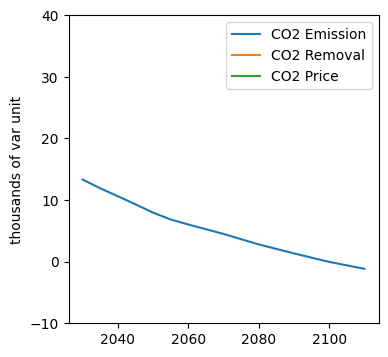

SSP1 objective value: 2283699.75
stor scenario: SSP1


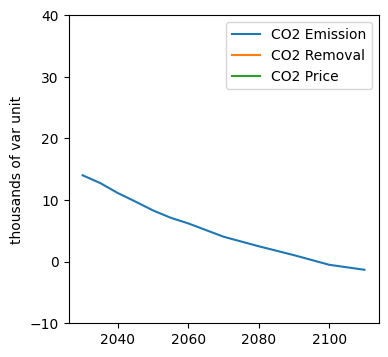

SSP2 objective value: 2808249.0
stor scenario: SSP2


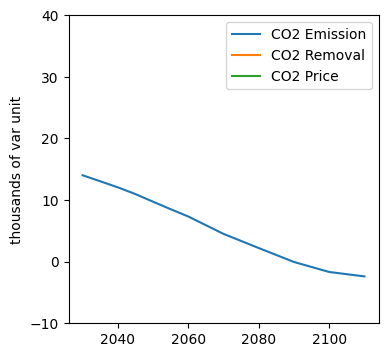

SSP4 objective value: 2714930.0
stor scenario: SSP4


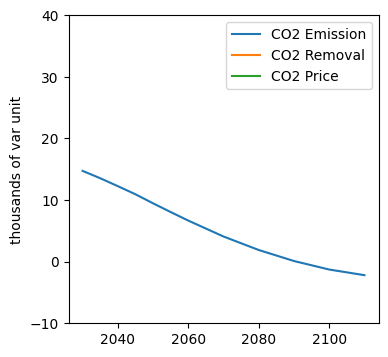

In [7]:
parameters = {
    "LED": 0.0,
    "SSP1": 0.0,
    "SSP2": 0.0,
    "SSP3": 0.0,
    "SSP4": 0.0,
    "SSP5": 0.0,
    }

for ssp in ssps:
    mp = ixmp.Platform()

    sbase = message_ix.Scenario(mp, model=f'SSP_dev_{ssp}_v1.0_materials-dac-co2split', 
                                scenario="baseline")
    s2run = sbase.clone(
        f"SSP_dev_{ssp}_v1.0_materials-dac-co2split",
        f"1000f_no-dac",
        f"{ssp}_dev 1000f carbon budget with all SSP-specific parameter",
        keep_solution=False, 
    )
    s2run.check_out()
    
    # prohibit DAC deployment
    parnames = ["growth_activity_up","soft_activity_up","initial_activity_up"]
    for name in parnames:
        df2rem = s2run.par(name, {"technology":"DAC_mpen"})
        df2add = df2rem.copy()
        df2add["value"] = parameters[ssp]

        s2run.remove_par(name, df2rem)
        s2run.add_par(name, df2add)
    
    ## add emission bound
    s2run.add_par('bound_emission', ['World', 'TCE', 'all', 'cumulative'], value=4046, unit="tC")
    
    
    # commit and run
    s2run.commit(comment=f"{ssp}_dev 1000f with DAC and all SSP-specific parameters")
    s2run.set_as_default()

    s2run.solve(solve_options={'scaind': '-1'})
    print(ssp, "objective value:", s2run.var("OBJ")["lvl"])

    # Get Report
    print("stor scenario:", ssp)
    plotvars(s2run)
            
    # CLOSE CONNECTION
    mp.close_db()




# With DAC scenarios

## All SSP parameters

LED objective value: 1919944.0
stor scenario: LED


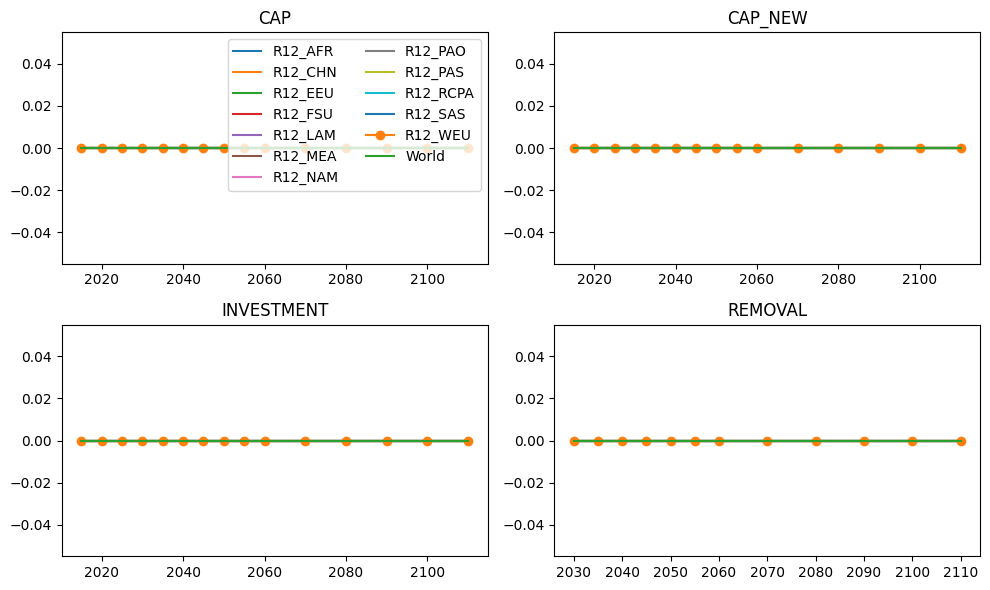

SSP1 objective value: 2286814.0
stor scenario: SSP1


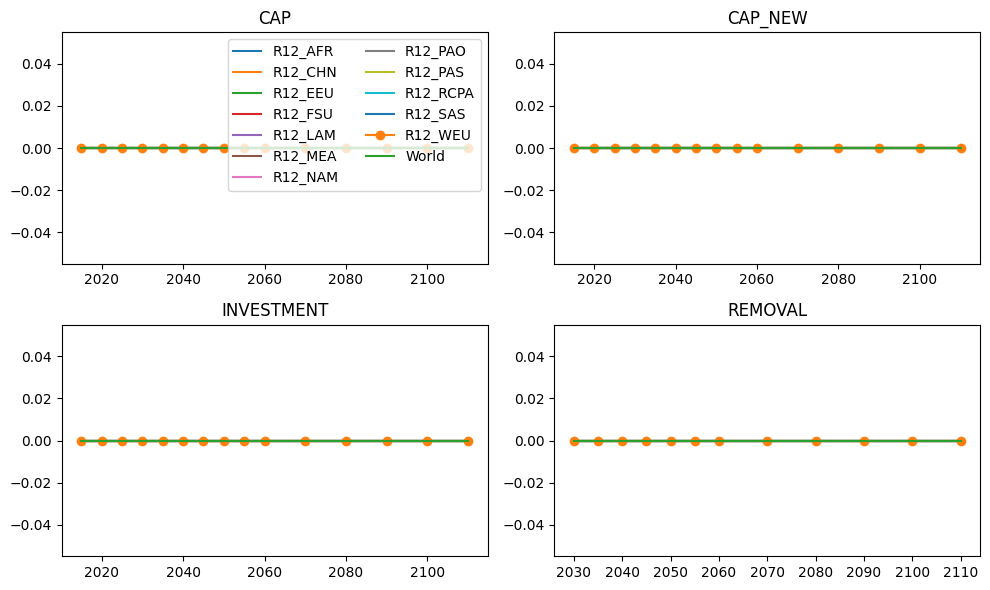

SSP2 objective value: 2826348.0
stor scenario: SSP2


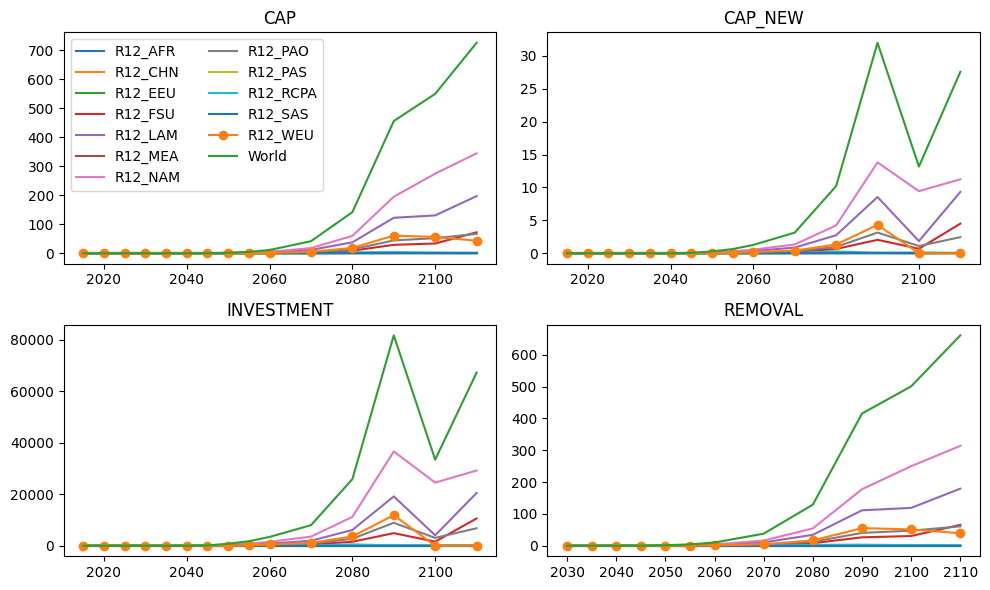

SSP4 objective value: 2690122.25
stor scenario: SSP4


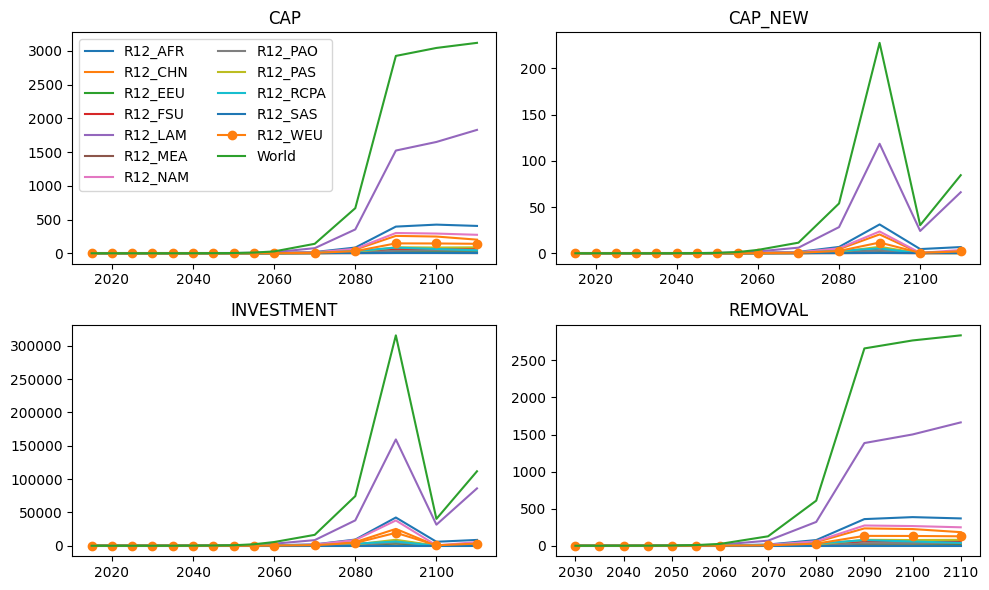

In [8]:
parameters = {
    "LED":{
        "co2storage": 0.25,
        "co2rate"   : 4000/3.667,
        "dacupscale": 0.05,
        "daccost"   : [0.92,0.87,0.82,0.79,0.76,0.74,0.72,0.71,0.70,0.70,0.70,0.70],
        "dacenergy" : [0.92,0.87,0.82,0.79,0.76,0.74,0.72,0.71,0.70,0.70,0.70,0.70],
        "maxfco2sto": 1.0,
        "minfco2sto": 0.0,
    },
    "SSP1":{
        "co2storage": 0.25,
        "co2rate"   : 4000/3.667,
        "dacupscale": 0.05,
        "daccost"   : [0.92,0.87,0.82,0.79,0.76,0.74,0.72,0.71,0.70,0.70,0.70,0.70],
        "dacenergy" : [0.92,0.87,0.82,0.79,0.76,0.74,0.72,0.71,0.70,0.70,0.70,0.70],
        "maxfco2sto": 1.0,
        "minfco2sto": 0.0,
    },
    "SSP2":{
        "co2storage": 0.50,
        "co2rate"   : 9000/3.667,
        "dacupscale": 0.10,
        "daccost"   : [0.87,0.79,0.70,0.64,0.59,0.56,0.54,0.51,0.51,0.51,0.50,0.50],
        "dacenergy" : [0.87,0.79,0.70,0.64,0.59,0.56,0.54,0.51,0.51,0.51,0.50,0.50],
        "maxfco2sto": 1.0,
        "minfco2sto": 0.0,
    },
    "SSP3":{#
        "co2storage": 1.00,
        "co2rate"   : 15000/3.667,
        "dacupscale": 0.15,
        "daccost"   : [0.92,0.87,0.82,0.79,0.76,0.74,0.72,0.71,0.70,0.70,0.70,0.70], # <<<<< check
        "dacenergy" : [0.92,0.87,0.82,0.79,0.76,0.74,0.72,0.71,0.70,0.70,0.70,0.70], # <<<<< check
        "maxfco2sto": 1.0,
        "minfco2sto": 0.0,
    },
    "SSP4":{#
        "co2storage": 1.00,
        "co2rate"   : 15000/3.667,
        "dacupscale": 0.15,
        "daccost"   : [0.82,0.70,0.58,0.50,0.43,0.39,0.35,0.32,0.31,0.31,0.30,0.30],
        "dacenergy" : [0.82,0.70,0.58,0.50,0.43,0.39,0.35,0.32,0.31,0.31,0.30,0.30],
        "maxfco2sto": 1.0,
        "minfco2sto": 0.0,
    },
    "SSP5":{
        "co2storage": 1.00,
        "co2rate"   : 15000/3.667,
        "dacupscale": 0.15,
        "daccost"   : [0.82,0.70,0.58,0.50,0.43,0.39,0.35,0.32,0.31,0.31,0.30,0.30],
        "dacenergy" : [0.82,0.70,0.58,0.50,0.43,0.39,0.35,0.32,0.31,0.31,0.30,0.30],
        "maxfco2sto": 1.0,
        "minfco2sto": 0.5,
    },
    
}

mp = ixmp.Platform()

storbase = message_ix.Scenario(mp, model=f'SSP_dev_SSP5_v0.1_dac', scenario="1000f_v0.14_dac-co2split_mpen5")
nodes = [node for node in storbase.set("node") if node not in ["World","R12_GLB"]]
years = list(sorted(set(storbase.vintage_and_active_years()["year_act"])))
years = [year for year in years if year > 2025]
len_periods = {2025:5, 2030:5, 2035:5, 2040:5, 2045:5, 2050:5,
               2055:5, 2060:5, 2070:10, 2080:10, 2090:10, 2100:10, 2110:10}
modes = ["M1","M2","M3"]

        

for ssp in ssps:
#for ssp in ["SSP3","SSP4"]:
    sbase = message_ix.Scenario(mp, model=f'SSP_dev_{ssp}_v1.0_materials-dac-co2split', 
                                scenario="baseline")
    
    s2run = sbase.clone(
        f"SSP_dev_{ssp}_v1.0_materials-dac-co2split",
        f"1000f_all-ssp-param",
        f"{ssp}_dev 1000f carbon budget with all SSP-specific parameter",
        keep_solution=False, 
    )
    s2run.check_out()
    
    ## add emission bound
    s2run.add_par('bound_emission', ['World', 'TCE', 'all', 'cumulative'], value=4046, unit="tC")
    
    # Updating storage volume limits
    df_stor_rem = s2run.par("bound_activity_up", {"technology":"co2_storcumulative"})
    df_stor_add = df_stor_rem.copy()
    df_stor_add["value"] = df_stor_add["value"].mul(parameters[ssp]["co2storage"]) # ultimate potential x fraction
    
    s2run.remove_par("bound_activity_up", df_stor_rem)
    s2run.add_par("bound_activity_up", df_stor_add)
    
        
    # Updating market penetration rates
    #DAC_mpen_rem = s2run.par("growth_activity_up", {"technology":"DAC_mpen"})
    #DAC_mpen_add = DAC_mpen_rem.copy()
    #DAC_mpen_add["value"] = parameters[ssp]["dacupscale"]

    #s2run.remove_par("growth_activity_up", DAC_mpen_rem)
    #s2run.add_par("growth_activity_up", DAC_mpen_add)
        
    


    # Updating DAC costs
    #for node in nodes:
    #    for tech in ["dac_lt","dac_hte","dac_htg"]:
    #        df2rem = s2run.par("inv_cost",{"technology":tech,"node_loc":node})

    #        # copying df cost
    #        df2add = df2rem.copy()
    #        df2add["value"] = [df2add["value"][0]*idx for idx in parameters[ssp]["daccost"]]

    #        s2run.remove_par("inv_cost", df2rem)
    #        s2run.add_par("inv_cost", df2add)

    
    
    
    # Updating DAC energy requirements
    #for y in range(len(years)):
    #    df2rem = s2run.par("input", {"technology":["dac_lt","dac_hte","dac_htg"],"year_vtg":years[y]})

    #    # copying df cost
    #    df2add = df2rem.copy()
    #    df2add["value"] = df2add["value"].mul(parameters[ssp]["dacenergy"][y])

    #    s2run.remove_par("input", df2rem)
    #    s2run.add_par("input", df2add)
    
    

    # Updating Max FCO2 share
    ## adding share constraint of cumulative activity
    s2run.add_set("shares","fco2storshare")

    ## creating lower and upper bound dataframes
    list_mode_ups = []
    for node in nodes:
        mode_up = make_df("share_mode_up",
            shares = "fco2storshare",
            node_share = node,
            technology = "co2_storcumulative",
            mode = "M1",
            year_act = 2100,
            time = "year",
            value = parameters[ssp]["maxfco2sto"],
            unit = "-"
        )
        list_mode_ups += [mode_up]
    df_mode_ups = pd.concat(list_mode_ups)
    s2run.add_par("share_mode_up", df_mode_ups)

    
    
    

    
    # Updating Min FCO2 share 
    ## creating lower and upper bound dataframes
    list_mode_los = []
    for node in nodes:
        mode_lo = make_df("share_mode_lo",
            shares = "fco2storshare",
            node_share = node,
            technology = "co2_storcumulative",
            mode = "M1",
            year_act = 2100,
            time = "year",
            value = parameters[ssp]["minfco2sto"],
            unit = "-"
        )
        list_mode_los += [mode_lo]
    df_mode_los = pd.concat(list_mode_los)
    s2run.add_par("share_mode_lo", df_mode_los)

    
    
    # Max CO2 injection 
    # Updating storage volume limits
    df_co2rate_rem = s2run.par("bound_activity_up", {"technology":"co2_stor_glb"})
    df_co2rate_add = df_co2rate_rem.copy()
    df_co2rate_add["value"] = parameters[ssp]["co2rate"]
    
    s2run.remove_par("bound_activity_up", df_co2rate_rem)
    s2run.add_par("bound_activity_up", df_co2rate_add)
    

    
    # commit and run
    s2run.commit(comment=f"{ssp}_dev 1000f with DAC and all SSP-specific parameters")
    s2run.set_as_default()

    s2run.solve(solve_options={'scaind': '-1'}) # 'barcrossalg': '2',
    print(ssp, "objective value:", s2run.var("OBJ")["lvl"])

    # Get Report
    print("stor scenario:", ssp)
    scenariotec = ['dac_lt','dac_hte','dac_htg']
    scenario_report = get_report(s2run,scenariotec)
            
# CLOSE CONNECTION
mp.close_db()




# Without DAC

## All SSPs parameters 

LED objective value: 1919944.0
stor scenario: LED


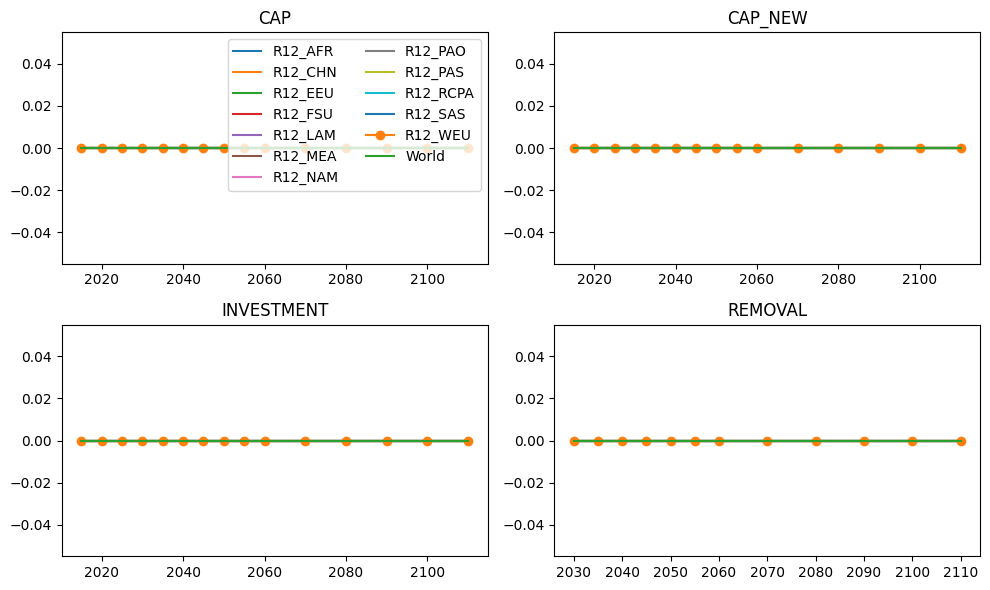

SSP1 objective value: 2286814.0
stor scenario: SSP1


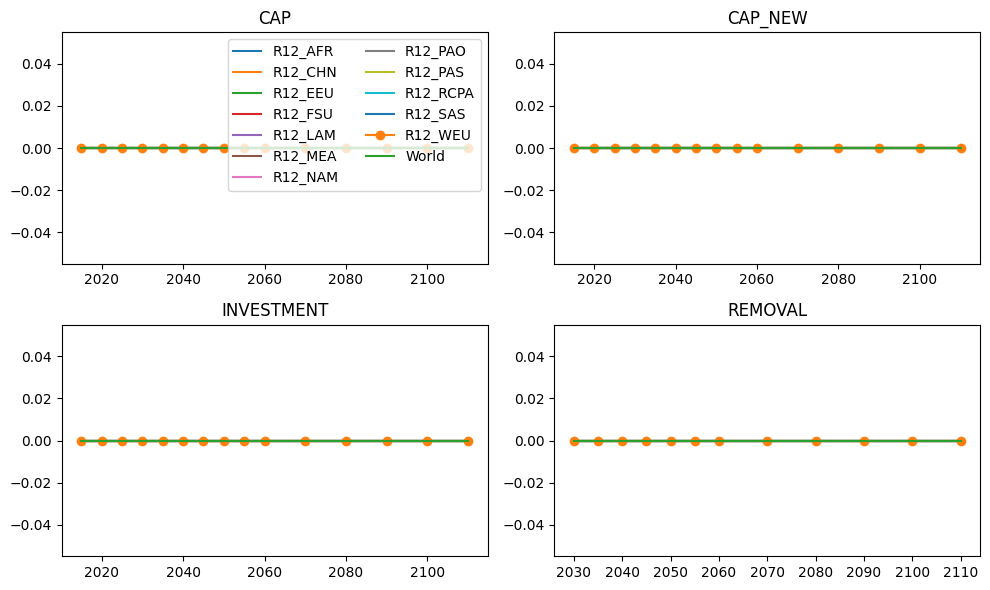

SSP2 objective value: 2827900.0
stor scenario: SSP2


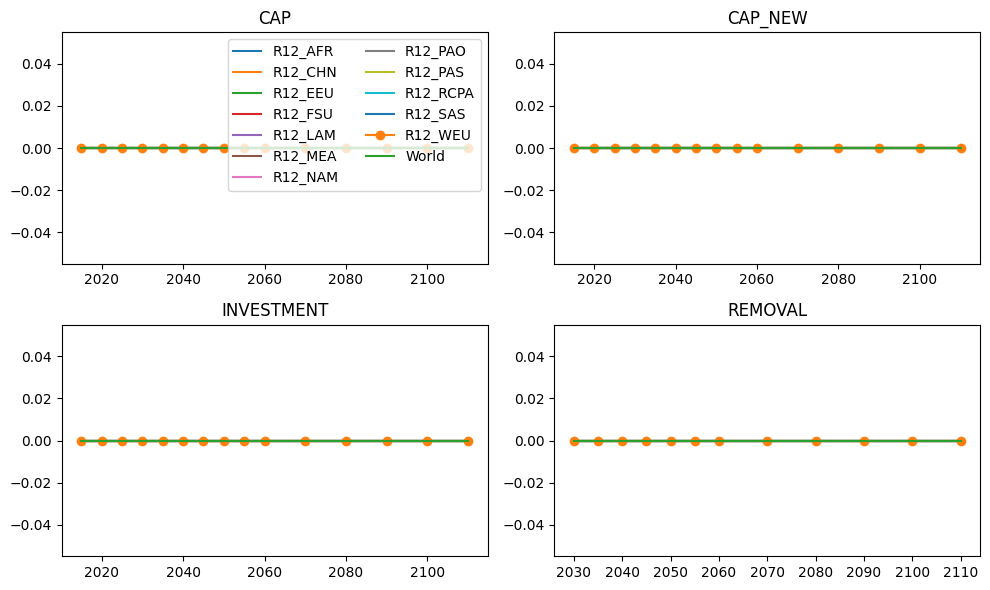

SSP4 objective value: 2714930.0
stor scenario: SSP4


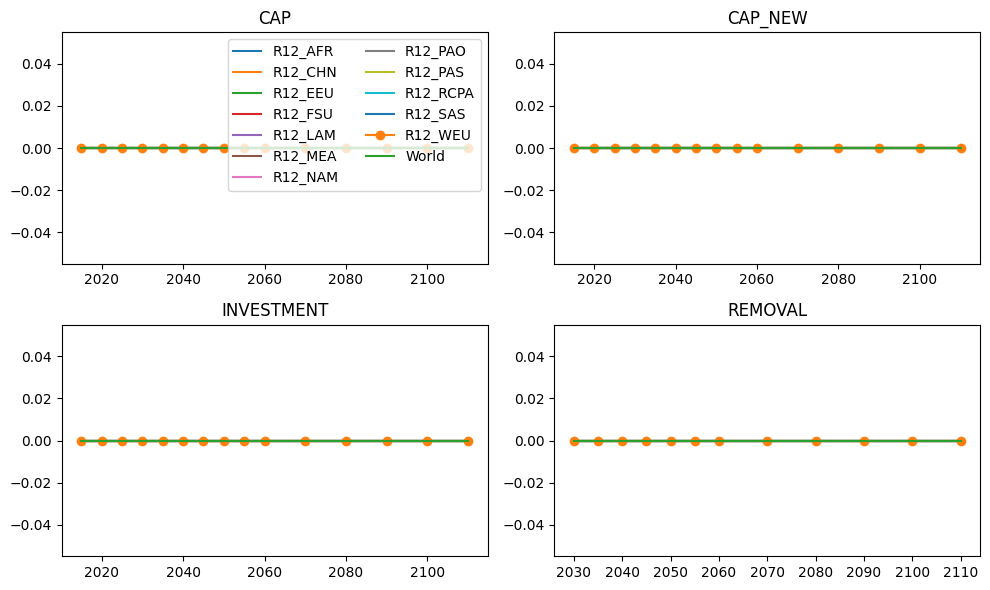

In [9]:
parameters = {
    "LED" : 0.0,
    "SSP1": 0.0,
    "SSP2": 0.0,
    "SSP3": 0.0,
    "SSP4": 0.0,
    "SSP5": 0.0,
    }

mp = ixmp.Platform()


for ssp in ssps:
    f"SSP_dev_{ssp}_v1.0_materials-dac-co2split",
    f"1000f_all-ssp-param",
        
    sbase = message_ix.Scenario(mp, model=f'SSP_dev_{ssp}_v1.0_materials-dac-co2split', 
                                scenario="1000f_all-ssp-param")
    s2run = sbase.clone(
        f"SSP_dev_{ssp}_v1.0_materials-dac-co2split",
        f"1000f_all-ssp-param_no-dac",
        f"{ssp}_dev 1000f carbon budget with all SSP-specific parameter",
        keep_solution=False, 
    )
    s2run.check_out()
    
    
    
    # Updating market penetration parameters
    parnames = ["growth_activity_up","soft_activity_up","initial_activity_up"]
    for name in parnames:
        df2rem = s2run.par(name, {"technology":"DAC_mpen"})
        df2add = df2rem.copy()
        df2add["value"] = parameters[ssp]

        s2run.remove_par(name, df2rem)
        s2run.add_par(name, df2add)

    
    
    # commit and run
    s2run.commit(comment=f"{ssp}_dev 1000f with DAC and all SSP-specific parameters")
    s2run.set_as_default()

    s2run.solve(solve_options={'scaind': '-1'})
    print(ssp, "objective value:", s2run.var("OBJ")["lvl"])

    # Get Report
    print("stor scenario:", ssp)
    scenariotec = ['dac_lt','dac_hte','dac_htg',]
    scenario_report = get_report(s2run,scenariotec)
            
# CLOSE CONNECTION
mp.close_db()




# Create default baseline scenarios